In [352]:
import pandas as pd
import numpy as np
import glob
import os
import shutil

# Create EV-files:

1. ev-files with actual events, 3-column format

In [2]:
def make_ev_files(sub, ses, run, evs=('go_trial', 'failed_stop', 'successful_stop')):
    fn = './data/deriv/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-stop_run-{run}_events.tsv'.format(**{'sub':sub, 'ses':ses, 'run':run})
    output_dir = './data/feat2_files/sub-{sub}/ses-{ses}/run-{run}/evs/'.format(**{'sub':sub, 'ses':ses, 'run':run})
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    events = pd.read_csv(fn, sep='\t')
    events['weight'] = 1.
    events['onset'] -= 1.5  # slice timing correction

    for i, ev in enumerate(evs):
        events.loc[events['trial_type']==ev, ['onset', 'duration', 'weight']].to_csv(output_dir+'{}.txt'.format(ev), sep='\t', index=False, header=False)

subjects = np.arange(1, 19)
sessions = ['se', 'me']
runs = [1,2,3]

for sub in subjects:
    for ses in sessions:
        if sub == 12 and ses == 'me':
            continue
            
        for run in runs:
            if sub == 17 and run == 3:
                continue
            make_ev_files(str(sub).zfill(2), ses, run)

2. ev-files with motion parameters that are not convolved

In [3]:
def make_motion_ev_files(sub, ses, run, evs=('trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement')):

    output_dir = './data/feat_files/sub-{sub}/ses-{ses}/run-{run}/evs/'.format(**{'sub':sub, 'ses':ses, 'run':run})

    if ses == 'se':
        fn = './data/deriv/fmriprep/sub-{sub}/ses-se/func/sub-{sub}_ses-se_task-stop_run-{run}_desc-confounds_regressors.tsv'.format(**{'sub':sub, 'run':run})
    else:
        fn = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-1_desc-confounds_regressors.tsv'.format(**{'sub':sub, 'run':run})

    events = pd.read_csv(fn, sep='\t')

    for i, ev in enumerate(evs):
        events[ev].fillna(0).to_csv(output_dir+'{}.txt'.format(ev), sep='\t', index=False, header=False)
    
    

subjects = np.arange(1, 19)
sessions = ['se', 'me']
runs = [1,2,3]

for sub in subjects:
    for ses in sessions:
        if sub == 12 and ses == 'me':
            continue
            
        for run in runs:
            if sub == 17 and run == 3:
                continue
            make_motion_ev_files(str(sub).zfill(2), ses, run)

In [9]:
import nibabel as nib
print(nib.load('./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz').header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 121 144 121 343   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  1.6 1.6 1.6 3.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 8
cal_max         : 5019.284
cal_min         : -634.43384
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v0.5.2.post5+0.'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -96.

In [7]:
import nibabel as nib
print(nib.load('./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz').header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 121 144 121 343   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.  1.6 1.6 1.6 3.  1.  1.  1. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 8
cal_max         : 4991.51
cal_min         : -780.31006
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'xform matrices modified by FixHeaderApplyTransforms (niworkflows v0.5.2.post5+0.'
aux_file        : b''
qform_code      : aligned
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : -96.0

### At this point in the pipeline, we manually create a single .fsf-file in FEAT

Afterwards, we make copies of this .fsf-file for each subject & session & run, and change the filenames that the fsf-file points to.

In [19]:
!ls ./data/deriv/fmriprep/sub-01/ses-me/func/

sub-01_ses-me_task-stop_run-1_echo-1_desc-confounds_regressors.tsv
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_boldref.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-aparcaseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-aseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc-hp_tsnr.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_boldref.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_desc-aparcaseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_desc-aseg_dseg.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_desc-brain_mask.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-T1w_de

In [15]:
with open('./data/feat_files/sub-01/ses-se/run-1.fsf', 'r') as f:
    txt = f.read()

In [74]:
def fix_fsf_file(sub, ses, run):
    # read fsf as txt
    with open('./data/feat_files/sub-01/ses-se/run-1.fsf', 'r') as f:
        fsf = f.read()
        
    # replace output directory
    fsf = fsf.replace("/home/stevenm/MultiEchoEPISeq/data/feat_files/sub-01/ses-se/run-1/",
                      "/home/stevenm/MultiEchoEPISeq/data/feat_files/sub-{}/ses-{}/run-{}/".format(str(sub).zfill(2), ses, run))
    
    # replace filename, NB: no extension to fn..
    if ses == 'me':
        fn_to_run = "/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-stop_run-{run}_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_bold".format(**{'sub':sub, 'ses':ses, 'run':run})
    else:
        fn_to_run = "/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-stop_run-{run}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold".format(**{'sub':sub, 'ses':ses, 'run':run})

    fsf = fsf.replace("/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold",
                      fn_to_run)

    # replace ev locations
    fsf = fsf.replace("/home/stevenm/MultiEchoEPISeq/data/feat_files/sub-01/ses-se/run-1/evs/",
                      "/home/stevenm/MultiEchoEPISeq/data/feat_files/sub-{sub}/ses-{ses}/run-{run}/evs/".format(**{'sub':sub, 'ses':ses, 'run':run}))
    
    # save fsf as txt
    with open('./data/feat_files/sub-{}/ses-{}/run-{}/model.fsf'.format(sub, ses, run), 'w') as f:
        f.write(fsf)
    
fix_fsf_file('01', 'se', 2)

In [75]:
orig_fsf = './data/feat_files/sub-01/ses-se/run-1.fsf'

subjects = np.arange(1, 19)
sessions = ['se', 'me']
runs = [1,2,3]

for sub in subjects:
    for ses in sessions:
        if sub == 12 and ses == 'me':
            continue
            
        for run in runs:
            if sub == 17 and run == 3:
                continue
                
            else:
                feat_dir_this_run = './data/feat_files/sub-{}/ses-{}/run-{}/'.format(str(sub).zfill(2), ses, run)
                shutil.copy(src=orig_fsf, dst=feat_dir_this_run + 'model.fsf')
                
                fix_fsf_file(str(sub).zfill(2), ses, run)

In [76]:
all_fsfs = glob.glob('./data/feat_files/sub-*/ses-*/run*/*.fsf')
all_fsfs.sort()

In [77]:
def run_feat(fsf_file):
    print(fsf_file)
    import subprocess
    return_code = subprocess.run(["feat", fsf_file])
    print('{}: {}'.format(fsf_file, return_code))
    return return_code

In [ ]:
# parallel
import multiprocessing as mp

with mp.Pool(5) as p:
    outputs = p.map(run_feat, all_fsfs)

./data/feat_files/sub-02/ses-me/run-1/model.fsf
./data/feat_files/sub-01/ses-me/run-1/model.fsf
./data/feat_files/sub-03/ses-me/run-1/model.fsf
./data/feat_files/sub-04/ses-me/run-1/model.fsf
./data/feat_files/sub-05/ses-me/run-1/model.fsf


## Flame from command line

In [240]:
#### test flameo command line

import pickle as pkl
copes = []
varcopes = []

def load_contrasts(contrast, session='se'):
    copes = []
    varcopes = []

    for sub in np.arange(1,19):
        print(sub, end='... ')
        if sub == 12:
            continue
        else:
            if session == 'se':
                with open('./data/deriv/fmriprep/sub-{}/ses-se/model_onset-shift/firstlevel_fwhm-5.pkl'.format(str(sub).zfill(2)), 'rb') as f:
                    model = pkl.load(f)
            else:
                with open('./data/deriv/fmriprep/sub-{}/ses-me/model_onset-shift/firstlevel_fwhm-5_comb-optcomb.pkl'.format(str(sub).zfill(2)), 'rb') as f:
                    model = pkl.load(f)
                    
            copes.append(model.compute_contrast([contrast], output_type='effect_size'))
            varcopes.append(model.compute_contrast([contrast], output_type='effect_variance'))
    return nilearn.image.concat_imgs(copes), nilearn.image.concat_imgs(varcopes)

contrasts_se = {'failed_stop - go_trial': load_contrasts('failed_stop - go_trial', session='se'),
                'successful_stop - go_trial': load_contrasts('successful_stop - go_trial', session='se'),
                'failed_stop - successful_stop': load_contrasts('failed_stop - successful_stop', session='se')}

contrasts_me = {'failed_stop - go_trial': load_contrasts('failed_stop - go_trial', session='me'),
                'successful_stop - go_trial': load_contrasts('successful_stop - go_trial', session='me'),
                'failed_stop - successful_stop': load_contrasts('failed_stop - successful_stop', session='me')}

1... 

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 3 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


18... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 1... 2... 3... 4... 5... 6... 7... 8... 9... 10... 11... 12... 13... 14... 15... 16... 17... 18... 

## Level 3 GLM: Compare single-echo vs multi-echo directly
Concatenate all COPEs and varCOPEs

In [320]:
keys = list(contrasts_se.keys())
contrasts_all = {key: (nilearn.image.concat_imgs([contrasts_se[key][0], contrasts_me[key][0]]),
                       nilearn.image.concat_imgs([contrasts_se[key][1], contrasts_me[key][1]])) for key in keys}

for key, items in contrasts_all.items():
    os.makedirs('flameo/level3/contrast-{}'.format(key.replace(' ', '')), exist_ok=True)
    nib.save(items[0], 'flameo/level3/contrast-{}/copes.nii.gz'.format(key.replace(' ', '')))
    nib.save(items[1], 'flameo/level3/contrast-{}/varcopes.nii.gz'.format(key.replace(' ', '')))

Make .mat, .con, .grp files for flameo

In [357]:
# make design for within-subject, between-run second level analysis
id_mat = np.eye(17)
id_mat = np.vstack([id_mat, id_mat])
random_group = np.ones(shape=(17*2, 1))
run_contrast = np.ones(shape=(17*2, 1))
run_contrast[17:] *= -1

# Design matrix
design_matrix = np.hstack([run_contrast, id_mat])
pd.DataFrame(design_matrix).to_csv('./flameo/level3/design_matrix.csv', sep='\t', index=None, header=False)
os.system('Text2Vest flameo/level3/design_matrix.csv flameo/level3/design.mat')

# Random group specification
grp_matrix = random_group
pd.DataFrame(grp_matrix).to_csv('./flameo/level3/design_grp.csv', sep='\t', index=None, header=False)
os.system('Text2Vest flameo/level3/design_grp.csv flameo/level3/design.grp')

# Contrast specification
contrast = np.hstack([np.array([1,-1])[:,np.newaxis], np.zeros((2, 17))])
pd.DataFrame(contrast).to_csv('./flameo/level3/design_contrast.csv', sep='\t', index=None, header=False)
os.system('Text2Vest flameo/level3/design_contrast.csv flameo/level3/design.con')

0

In [359]:
Make flameo commands & run

SyntaxError: invalid syntax (<ipython-input-359-04fa0fef6917>, line 1)

In [358]:
design_template = os.path.join('flameo', '{}', '{}')
path_template = os.path.join('flameo', '{}', 'contrast-{}', '{}')
session = 'level3'
for runmode in ['fe', 'flame1', 'ols']:
    for contrast in contrasts_all.keys():
        print('{} {} {}'.format(runmode, contrast, session), end=': ')
        flameo_cmd = ['flameo',
                      ' --mask=', os.path.join('flameo', 'sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
                      ' --cope=', path_template.format(session, contrast.replace(' ', ''), 'copes.nii.gz'),
                      ' --varcope=', path_template.format(session, contrast.replace(' ', ''), 'varcopes.nii.gz'),
                      ' --dm=', design_template.format(session, 'design.mat'),
                      ' --tc=', design_template.format(session, 'design.con'),
                      ' --cs=', design_template.format(session, 'design.grp'),
                      ' --runmode=', runmode,
                      ' --logdir=', path_template.format(session, contrast.replace(' ', ''), runmode)]
        flameo_cmd = ''.join(flameo_cmd)
        print(flameo_cmd)

        print(os.system(flameo_cmd))

fe failed_stop - go_trial level3: flameo --mask=flameo/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --cope=flameo/level3/contrast-failed_stop-go_trial/copes.nii.gz --varcope=flameo/level3/contrast-failed_stop-go_trial/varcopes.nii.gz --dm=flameo/level3/design.mat --tc=flameo/level3/design.con --cs=flameo/level3/design.grp --runmode=fe --logdir=flameo/level3/contrast-failed_stop-go_trial/fe
0
fe successful_stop - go_trial level3: flameo --mask=flameo/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --cope=flameo/level3/contrast-successful_stop-go_trial/copes.nii.gz --varcope=flameo/level3/contrast-successful_stop-go_trial/varcopes.nii.gz --dm=flameo/level3/design.mat --tc=flameo/level3/design.con --cs=flameo/level3/design.grp --runmode=fe --logdir=flameo/level3/contrast-successful_stop-go_trial/fe
0
fe failed_stop - successful_stop level3: flameo --mask=flameo/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-bra

## Analyze GLMs
##### Extract influence on t-values

$t = \frac{\beta}{\sqrt{variance}}$

For fixed-effects: variance = within-subject variance $\sigma^2$

For random-effects: variance = within $\sigma^2$ + between subject variance $\Sigma^2$

By taking the voxel-wise difference between random effects variance and fixed-effects variance, we estimate the inter-subject variance

In [ ]:
# make second level design files
design_str = "/NumWaves\t1\n/NumPoints\t17\n/PPheights\t\t1.00000e+00\n\n/Matrix\n" + "1.00000e+00\n"*17
grp_str = "/NumWaves\t1\n/NumPoints\t17\n\n/Matrix" + "\n1"*17

In [245]:
# get first-level COPEs and varCOPEs
second_levels_dir = './flameo'
for smooth in [0]:
    
    for session in ['se', 'me']:
        if session == 'se':
            contrasts = contrasts_se
        elif session == 'me':
            contrasts = contrasts_me
            
        for contrast in contrasts.keys():
            path = os.path.join(second_levels_dir, session, 'smoothing-{}'.format(smooth),
                         'contrast-{}'.format(contrast.replace(' ', '')))
            os.makedirs(path, exist_ok=True)

            # save three files necessary for flame
            con_str = "/ContrastName1\t{}\n/ContrastName2\t{}\n/NumWaves\t1\n/NumContrasts\t2\n/PPheights\t\t1.00000e+00\t1.0000e+00\n/RequiredEffect\t\t1119.478\t1119.478\n\n/Matrix\n1.0000e+00\n-1.0000e+11".format(contrast.replace(' ',''), '-' + contrast.replace(' ', ''))
            with open(os.path.join(path, 'design.mat'), 'w') as f:
                f.write(design_str)
            with open(os.path.join(path, 'design.con'), 'w') as f:
                f.write(con_str)
            with open(os.path.join(path, 'design.grp'), 'w') as f:
                f.write(grp_str)

            if smooth == 0:
                nib.save(contrasts[contrast][0], os.path.join(path, 'copes.nii.gz'))
                nib.save(contrasts[contrast][1], os.path.join(path, 'varcopes.nii.gz'))
            else:
                to_save_cope = nilearn.image.smooth_img(contrasts[contrast][0], smooth)
                to_save_varcope = nilearn.image.smooth_img(contrasts[contrast][1], smooth)
                nib.save(to_save_cope, os.path.join(path, 'copes.nii.gz'))
                nib.save(to_save_varcope, os.path.join(path, 'varcopes.nii.gz'))

In [220]:
!cp ./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz ./flameo

In [251]:
## make cmd and run
path_template = os.path.join('flameo', '{}', 'smoothing-{}', 'contrast-{}', '{}')
smooth = 0

for session in ['se', 'me']:
    for smooth in [0]:
        for runmode in ['fe', 'flame1', 'ols']:
            for contrast in contrasts_se.keys():
                print('{} {} {} {}'.format(smooth, runmode, contrast, session), end=': ')
                flameo_cmd = ['flameo',
                              ' --mask=', os.path.join('flameo', 'sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'),
                              ' --cope=', path_template.format(session, smooth, contrast.replace(' ', ''), 'copes.nii.gz'),
                              ' --varcope=', path_template.format(session, smooth, contrast.replace(' ', ''), 'varcopes.nii.gz'),
                              ' --dm=', path_template.format(session, smooth, contrast.replace(' ', ''), 'design.mat'),
                              ' --tc=', path_template.format(session, smooth, contrast.replace(' ', ''), 'design.con'),
                              ' --cs=', path_template.format(session, smooth, contrast.replace(' ', ''), 'design.grp'),
                              ' --runmode=', runmode,
                              ' --logdir=', path_template.format(session, smooth, contrast.replace(' ', ''), runmode)]
                flameo_cmd = ''.join(flameo_cmd)
                print(flameo_cmd)

                print(os.system(flameo_cmd))

0 fe failed_stop - go_trial se: flameo --mask=flameo/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --cope=flameo/se/smoothing-0/contrast-failed_stop-go_trial/copes.nii.gz --varcope=flameo/se/smoothing-0/contrast-failed_stop-go_trial/varcopes.nii.gz --dm=flameo/se/smoothing-0/contrast-failed_stop-go_trial/design.mat --tc=flameo/se/smoothing-0/contrast-failed_stop-go_trial/design.con --cs=flameo/se/smoothing-0/contrast-failed_stop-go_trial/design.grp --runmode=fe --logdir=flameo/se/smoothing-0/contrast-failed_stop-go_trial/fe
0
0 fe successful_stop - go_trial se: flameo --mask=flameo/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --cope=flameo/se/smoothing-0/contrast-successful_stop-go_trial/copes.nii.gz --varcope=flameo/se/smoothing-0/contrast-successful_stop-go_trial/varcopes.nii.gz --dm=flameo/se/smoothing-0/contrast-successful_stop-go_trial/design.mat --tc=flameo/se/smoothing-0/contrast-successful_stop-go_trial/design.c

0
0 flame1 failed_stop - successful_stop me: flameo --mask=flameo/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --cope=flameo/me/smoothing-0/contrast-failed_stop-successful_stop/copes.nii.gz --varcope=flameo/me/smoothing-0/contrast-failed_stop-successful_stop/varcopes.nii.gz --dm=flameo/me/smoothing-0/contrast-failed_stop-successful_stop/design.mat --tc=flameo/me/smoothing-0/contrast-failed_stop-successful_stop/design.con --cs=flameo/me/smoothing-0/contrast-failed_stop-successful_stop/design.grp --runmode=flame1 --logdir=flameo/me/smoothing-0/contrast-failed_stop-successful_stop/flame1
0
0 ols failed_stop - go_trial me: flameo --mask=flameo/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --cope=flameo/me/smoothing-0/contrast-failed_stop-go_trial/copes.nii.gz --varcope=flameo/me/smoothing-0/contrast-failed_stop-go_trial/varcopes.nii.gz --dm=flameo/me/smoothing-0/contrast-failed_stop-go_trial/design.mat --tc=flameo/me/smooth

## Plot commands

In [368]:
import os
import pandas
import numpy as np
import nibabel as nib
import glob

from nilearn.plotting import find_xyz_cut_coords
import matplotlib.pyplot as plt
from scipy.stats import norm
import re

def get_color(mask):
    if 'STN' in mask:
        return 'white'
    if 'STR' in mask:
        return 'blue'
    if 'PreSMA' in mask:
        return 'yellow'
    if 'ACC' in mask:
        return 'green'
    if 'M1' in mask:
        return 'pink'
    if 'GPi' in mask:
        return 'yellow'
    if 'GPe' in mask:
        return 'brown'
    if 'IFG' in mask:
        return 'orange'

# make dict of masks & filenames in 09c-space, get colors
fns = glob.glob('./masks/final_masks_mni09c_1mm/space*')
fns.sort()
names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_label-(?P<label>[a-zA-Z0-9]+)_probseg.nii.gz', fn).groupdict()['label'] for fn in fns]
roi_dict = dict(zip(names, fns))
for mask, fn in roi_dict.items():
    roi_dict[mask] = {}
    roi_dict[mask]['fn'] = fn
    roi_dict[mask]['color'] = get_color(mask)
    roi_dict[mask]['threshold'] = 0.1 if 'STN' in mask else 0.3

def get_prop_limits(props, current_limits):
    extent = current_limits[1]-current_limits[0]
    x0 = current_limits[0] + extent*props[0]
    x1 = current_limits[0] + extent*props[1]
    return (x0, x1)

def add_contours(disp, roi, thr=0.3, linewidth=1, color='white', **kwargs):
    from nilearn._utils.extmath import fast_abs_percentile
    from nilearn._utils.param_validation import check_threshold
    
    map_img = nib.load(roi)
    data = map_img.get_data()
    # threshold manually
    
    
    thr = check_threshold(thr, data,
                          percentile_func=fast_abs_percentile,
                          name='threshold')
    
    # Get rid of background values in all cases
    thr = max(thr, 1e-6)
    if data.max() > 1:
        thr = thr*100
    disp.add_contours(roi, levels=[thr], linewidth=linewidth, colors=[color], **kwargs)
    
def plot_secondlevel_results(zmaps, roi_map, bg_img=None, z_threshold=0, f=None, axes=None,
                            # brain_mask='../Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c.nii.gz',
                             roi_to_plot=('PreSMA', 'M1', 'ACC', 'rIFG', 'STR', 'GPe', 'GPi', 'STN'),
                             cut_coords=[None, None, None, None, None, None, None, None],
                             contrasts=('failed_stop - go_trial',
                                        'successful_stop - go_trial',
                                        'failed_stop - successful_stop'),
                             plot_columns=(0, 1, 3, 4, 6, 7),
                             empty_plots=False, skip_all_but_last=False,
                             **kwargs):
    
    if f is None:
        gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1])
        f, axes = plt.subplots(len(roi_to_plot), len(zmaps)+3, gridspec_kw=gridspec)  # add 3 columns: 2 interspace, 1 on the right for the colorbar
 
    if empty_plots:
        f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
        return f, axes
    
    all_cut_coords = []
    all_disps = []
    for row_n, roi in enumerate(roi_to_plot):
        # for debugging
        if skip_all_but_last:
            if row_n < (len(roi_to_plot)-1):
                continue
        
        # get cut coordinates based on 1 hemisphere (if applicable)
        if roi in ['STR', 'STN', 'PreSMA', 'GPe', 'GPi']:
            roi_map = roi_dict['l' + roi]
        else:
            roi_map = roi_dict[roi]
#        roi_map = make_conjunction_mask(roi_map['fn'], brain_mask)
        if roi == 'rIFG':
            ## saggital
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[0:1]
            else:
                this_cut_coords = cut_coords[row_n]
            display_mode='x'
            plot_rois = ['rIFG', 'M1', 'rPreSMA']
        elif roi == 'STR':
            ## axial view
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[2:3]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='z'
            plot_rois = ['rIFG', 'M1',
                         'lSTR', 'lGPe', 'lGPi', 'lSTN',
                         'rSTR', 'rGPe', 'rGPi', 'rSTN']
        elif roi == 'STN':
            ## plot coronal view
            if cut_coords[row_n] is None:
                this_cut_coords = find_xyz_cut_coords(roi_map['fn'])[1:2]
            else:
                this_cut_coords = cut_coords[row_n]

            display_mode='y'
            plot_rois = ['rIFG', 'M1',
                         'lSTR', 'lGPe', 'lGPi', 'lSTN',
                         'rSTR', 'rGPe', 'rGPi', 'rSTN']

        all_cut_coords.append({display_mode: this_cut_coords[0]})
        
        # loop over contrasts for columns
        for col_n, map_n in zip(plot_columns, np.arange(len(zmaps))):
            zmap = zmaps[map_n]
            if skip_all_but_last:
                if col_n < (len(zmaps)-1):
                    continue
            
            if row_n == (len(roi_to_plot)-1) and col_n == (len(zmaps)-1):
                # plot colobar in the last plot
                cbar = False
            else:
                cbar = False
            
#             # do not plot in column 2 or 5
#             plot_col = col_n
#             if col_n > 1:
#                 plot_col = col_n + 1
#             if col_n > 3:
#                 plot_col = col_n + 2
                
            if isinstance(z_threshold, list):
                this_threshold = z_threshold[map_n]
            else:
                this_threshold = z_threshold
            ax = axes[row_n, col_n]
            
#             print(cbar)
            disp = plotting.plot_stat_map(zmap, bg_img=bg_img, 
                                          threshold=this_threshold, cut_coords=this_cut_coords,
                                          display_mode=display_mode, axes=ax, colorbar=cbar, **kwargs)
        
            # just plot *all* contours, always
            for roi_ in plot_rois:
                roi_map = roi_dict[roi_]
#             for roi_, roi_map in roi_dict.items():
#                 print(roi_map)
                add_contours(disp, roi=roi_map['fn'], thr=roi_map['threshold'], color=roi_map['color'])

            # set new xlimits if necessary (ie zoom for STN view)
            if 'STN' in roi and display_mode == 'z':
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([.25, .75], cur_xlim)
                new_ylim = get_prop_limits([.40, .90], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
            elif 'STN' in roi and display_mode == 'y':
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([.25, .75], cur_xlim)
                new_ylim = get_prop_limits([.25, .75], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
            elif 'STR' in roi and display_mode == 'z':
                this_key = [x for x in disp.axes.keys()]
                this_key = this_key[0]
                cur_xlim = disp.axes[this_key].ax.get_xlim()
                cur_ylim = disp.axes[this_key].ax.get_ylim()
                new_xlim = get_prop_limits([0, 1], cur_xlim)
                new_ylim = get_prop_limits([.3, 1], cur_ylim)
                disp.axes[this_key].ax.set_xlim(new_xlim[0], new_xlim[1])
                disp.axes[this_key].ax.set_ylim(new_ylim[0], new_ylim[1])
                
            all_disps.append(disp)
    
    # add labels
#     for ax, nm in zip(axes[0], zmaps.keys()):
#         ax.set_title(nm)
    if not skip_all_but_last:
        for row_n, ax in enumerate(axes[:,0]):
            cc = all_cut_coords[row_n]
            disp_mode = [x for x in cc.keys()][0]
            coord = cc[disp_mode]
            ax.annotate('%s = %d' %(disp_mode, int(coord)), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 0, 0),
                        xycoords=ax.yaxis.label, textcoords='offset points', rotation=90,
                        size=16, ha='right', va='center')

    f.set_size_inches(len(zmaps)*4, len(roi_to_plot)*4)
    
    return f, axes, all_disps

def _draw_colorbarSM2(colorbar_ax, vmin=3, vmax=6, truncation_limits=(0,6), offset=4., nb_ticks=4, flip=True):
    from matplotlib.colorbar import ColorbarBase
    from matplotlib import colors
    our_cmap = plotting.cm.cold_hot
    if flip:
        truncation_limits = [truncation_limits[1], truncation_limits[0]]
    ticks = np.linspace(truncation_limits[0], truncation_limits[1], nb_ticks)
    bounds = np.linspace(truncation_limits[0], truncation_limits[1], our_cmap.N)
    norm = colors.Normalize(vmin=-vmax, vmax=vmax)
    
    # some colormap hacking
    cmaplist = [our_cmap(i) for i in range(our_cmap.N)]
    istart = int(norm(-offset, clip=True) * (our_cmap.N - 1))
    istop = int(norm(offset, clip=True) * (our_cmap.N - 1))
    for i in range(istart, istop):
        cmaplist[i] = (0.5, 0.5, 0.5, 1.)  # just an average gray color
    our_cmap = our_cmap.from_list('Custom cmap', cmaplist, our_cmap.N)

    ColorbarBase(colorbar_ax, ticks=ticks, norm=norm,
                 orientation='vertical', cmap=our_cmap, boundaries=bounds,
                 spacing='proportional', format='%.2g')
    
    if flip:
        colorbar_ax.invert_yaxis()
        colorbar_ax.yaxis.tick_right()
    else:
        colorbar_ax.yaxis.tick_left()

    return colorbar_ax

from matplotlib import gridspec

def plot_3x3(zmaps, thresholds, roi_dict=roi_dict,
             titles=('SE > ME', 'SE > ME', 'SE > ME'),
             contrast_names=('Contrast 1', 'Contrast 2', 'Contrast 3'),
             vmax=6, colorbars=((3, 6), (3, 6)),
             colorbar_title='z-values'):
    
    gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                        width_ratios=[1, 0.05, 1, 0.05, 1, .1, .1, .1])
    gs = gridspec.GridSpec(3, len(zmaps)+5, **gridspec_kws)
    f, axes = plt.subplots(3, len(zmaps)+5, gridspec_kw=gridspec_kws)
    # add 5 columns: 3 interspaces, 2 colorbars

    f, axes, disps = plot_secondlevel_results(zmaps, roi_dict, z_threshold=thresholds,
                                              f=f, axes=axes,
                                              roi_to_plot=['rIFG', 'STR', 'STN'],
                                              cut_coords=[[52], None, [-13]],
                                              bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                                              plot_columns=(0, 2, 4),
                                              vmax=vmax, #colorbar=False, 
                                              annotate=False, empty_plots=False, 
                                              skip_all_but_last=False)
    axes[0,0].set_title(titles[0], size=16)
    axes[0,2].set_title(titles[1], size=16)
    axes[0,4].set_title(titles[2], size=16)
    
    for row in range(axes.shape[0]):
        axes[row,1].set_visible(False)
        axes[row,3].set_visible(False)
        axes[row,5].set_visible(False)
        if row in [0,1,2]:
            for col in [-3,-2,-1]:
                axes[row,col].set_visible(False)
                axes[row,col].set_visible(False)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    #loop over the columns (j) and rows(i) to populate subplots
    for j in range(5):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[0][0]+ext[0][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    width_mid = ext[2][0]+(ext[2][0]+ext[2][1]-ext[2][0])/2.
    mid_center = inv.transform( (width_mid, 1) )

    width_right = ext[4][0]+(ext[4][0]+ext[4][1]-ext[4][0])/2.
    right_center = inv.transform( (width_right, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .93, contrast_names[0], va="center", ha="center", size=16)
    plt.figtext(mid_center[0], .93, contrast_names[1], va="center", ha="center", size=16)
    plt.figtext(right_center[0], .93, contrast_names[2], va="center", ha="center", size=16)

    # colorbar
    thrs_ = thresholds
    if isinstance(thresholds, list):
        thrs_ = thresholds[0]
    
    cbar_ax1 = f.add_subplot(gs[1,-2])
    cbar_ax1 = _draw_colorbarSM2(colorbar_ax=cbar_ax1, 
                                 vmin=colorbars[0][0], vmax=colorbars[0][1],
                                 truncation_limits=colorbars[0], offset=thrs_, flip=False)
    
    if len(colorbars) == 2:
        cbar_ax2 = f.add_subplot(gs[1,-1])
        cbar_ax2 = _draw_colorbarSM2(colorbar_ax=cbar_ax2, 
                                     vmin=colorbars[1][0], vmax=colorbars[1][1],
                                     truncation_limits=(-colorbars[1][0], -colorbars[1][1]), 
                                     offset=thrs_, flip=True)
    cbar_ax1.set_title(colorbar_title, rotation=90, fontsize=16, ha='left', pad=75)

    return f, axes

def plot_3x6(zmaps, thresholds, roi_dict=roi_dict,
             titles=('Single echo', 'Multi echo', 'Single echo', 'Multi echo', 'Single echo', 'Multi echo'),
             contrast_names=('Contrast 1', 'Contrast 2', 'Contrast 3'),
             vmax=6, colorbars=((3, 6), (3, 6)),
             colorbar_title='z-values'):
    gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                    width_ratios=[1, 1, 0.05, 1, 1, .05, 1, 1, .1, .1, .1])
    gs = gridspec.GridSpec(3, len(zmaps)+5, **gridspec_kws)
    f, axes = plt.subplots(3, len(zmaps)+5, gridspec_kw=gridspec_kws)
    # add 5 columns: 3 interspaces, 2 colorbars

    f, axes, disps = plot_secondlevel_results(zmaps, roi_dict, z_threshold=thresholds,
                                              f=f, axes=axes,
                                              roi_to_plot=['rIFG', 'STR', 'STN'],
                                              cut_coords=[[52], None, [-13]],
                                              bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                                              vmax=vmax, #colorbar=False, 
                                              annotate=False, empty_plots=False, 
                                              skip_all_but_last=False)
    axes[0,0].set_title(titles[0], size=16)
    axes[0,1].set_title(titles[1], size=16)
    axes[0,3].set_title(titles[2], size=16)
    axes[0,4].set_title(titles[3], size=16)
    axes[0,6].set_title(titles[4], size=16)
    axes[0,7].set_title(titles[5], size=16)

    for row in range(axes.shape[0]):
        axes[row,2].set_visible(False)
        axes[row,5].set_visible(False)
        axes[row,8].set_visible(False)
        if row in [0,1,2]:
            for col in [-3,-2,-1]:
                axes[row,col].set_visible(False)
                axes[row,col].set_visible(False)

    # for titles: https://stackoverflow.com/questions/40936729/matplotlib-title-spanning-two-or-any-number-of-subplot-columns
    ext = []
    #loop over the columns (j) and rows(i) to populate subplots
    for j in range(8):
        # save the axes bounding boxes for later use
        ext.append([axes[0,j].get_window_extent().x0, axes[0,j].get_window_extent().width ])

    # make nice
    inv = f.transFigure.inverted()
    width_left = ext[0][0]+(ext[1][0]+ext[1][1]-ext[0][0])/2.
    left_center = inv.transform( (width_left, 1) )

    width_mid = ext[3][0]+(ext[4][0]+ext[4][1]-ext[3][0])/2.
    mid_center = inv.transform( (width_mid, 1) )

    width_right = ext[6][0]+(ext[7][0]+ext[7][1]-ext[6][0])/2.
    right_center = inv.transform( (width_right, 1) )

    # set column spanning title 
    # the first two arguments to figtext are x and y coordinates in the figure system (0 to 1)
    plt.figtext(left_center[0], .93, contrast_names[0], va="center", ha="center", size=16)
    plt.figtext(mid_center[0], .93, contrast_names[1], va="center", ha="center", size=16)
    plt.figtext(right_center[0], .93, contrast_names[2], va="center", ha="center", size=16)

    # colorbar
    thrs_ = thresholds
    if isinstance(thresholds, list):
        thrs_ = thresholds[0]
    
    cbar_ax1 = f.add_subplot(gs[1,-2])
    cbar_ax1 = _draw_colorbarSM2(colorbar_ax=cbar_ax1, 
                                 vmin=colorbars[0][0], vmax=colorbars[0][1],
                                 truncation_limits=colorbars[0], offset=thrs_, flip=False)
    
    if len(colorbars) == 2:
        cbar_ax2 = f.add_subplot(gs[1,-1])
        cbar_ax2 = _draw_colorbarSM2(colorbar_ax=cbar_ax2, 
                                     vmin=colorbars[1][0], vmax=colorbars[1][1],
                                     truncation_limits=(-colorbars[1][0], -colorbars[1][1]), 
                                     offset=thrs_, flip=True)
    cbar_ax1.set_title(colorbar_title, rotation=90, fontsize=16, ha='left', pad=75)

    return f, axes
    # f.savefig('./glm.pdf')#, bbox_inches='tight')

def order_maps_thresholds(zmaps_list, thresholds_list=None):
    """ Orders zmaps & thresholds for plotting """
    
    keys = [x for x in zmaps_list[0].keys()]
    zmaps_combined = [l[keys[i]] for i in range(len(keys)) for l in zmaps_list]
    
    if thresholds_list is not None:
        thresholds_combined = [t[i] for i in range(len(thresholds_list[0])) for t in thresholds_list]
        return zmaps_combined, thresholds_combined
    else:
        return zmaps_combined

## Inspect difference between sequences

In [369]:
nii_templ = './flameo/{}/contrast-{}/{}/zstat1.nii.gz'
contrasts = ['failed_stop-go_trial', 'successful_stop-go_trial', 'failed_stop-successful_stop']
runmode = 'flame1'

zmaps_diff_flame1_0mm = {contrast: nib.load(nii_templ.format('level3', contrast, runmode))
                         for contrast in contrasts}

thresholds_diff = [map_threshold(zmaps_diff_flame1_0mm[contr], 
                                 level=0.05, height_control='fdr')[1] for contr in contrasts]

# zmaps_combined, thresholds_combined = order_maps_thresholds([zmaps_se_flame1_0mm, zmaps_me_flame1_0mm],
#                                                              [thresholds_se, thresholds_me])

zmaps_ordered = [zmaps_diff_flame1_0mm[contrast] for contrast in contrasts]

In [370]:
thresholds_diff

[inf, inf, inf]

In [371]:
zmaps_diff_flame1_0mm

{'failed_stop-go_trial': <nibabel.nifti1.Nifti1Image at 0x7fdc92e99630>,
 'successful_stop-go_trial': <nibabel.nifti1.Nifti1Image at 0x7fdc92e99ba8>,
 'failed_stop-successful_stop': <nibabel.nifti1.Nifti1Image at 0x7fdc92e99b00>}

(<Figure size 864x864 with 35 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdc9260cef0>,
       dtype=object))

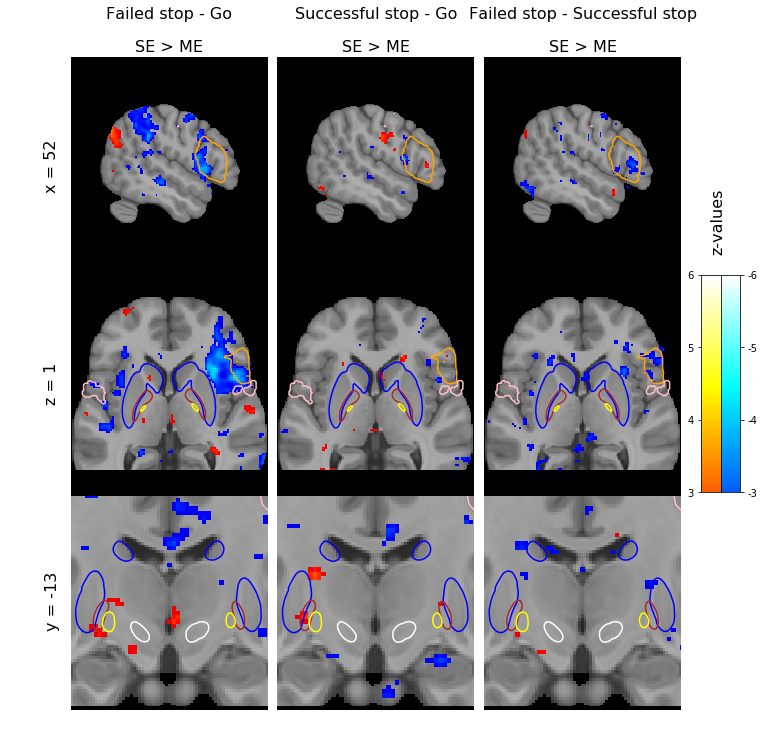

In [373]:
_ = plot_3x3(zmaps_ordered, 
             1.96,  # UNCORRECTED 
             contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop')
             )

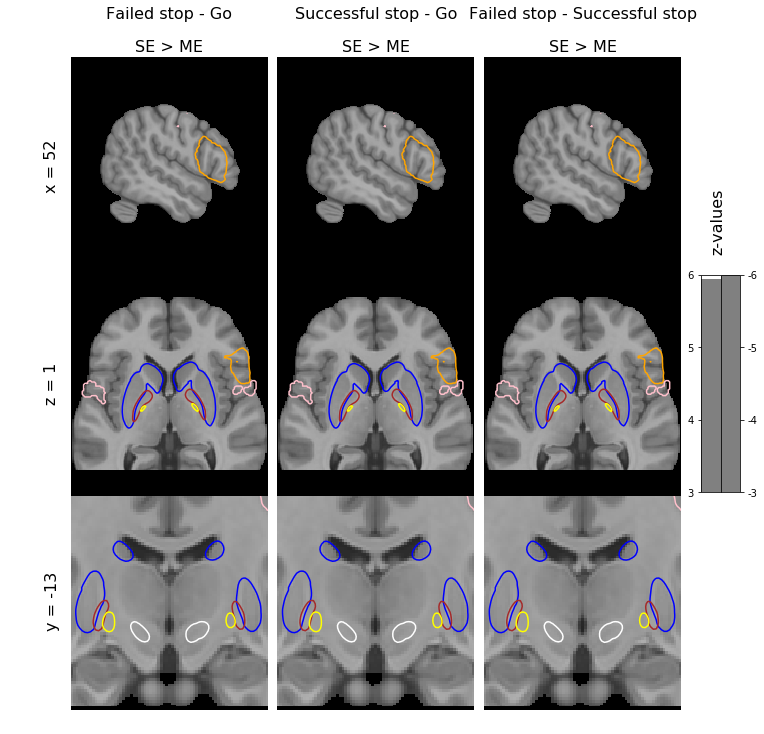

In [374]:
_ = plot_3x3(zmaps_ordered, 
             thresholds_diff, 
             contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop')
             )

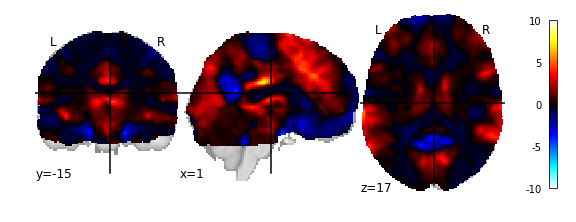

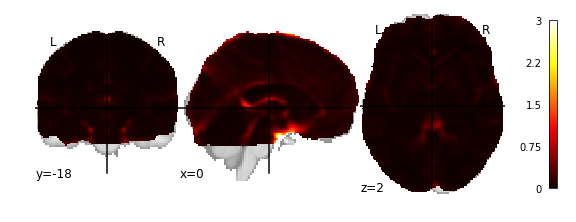

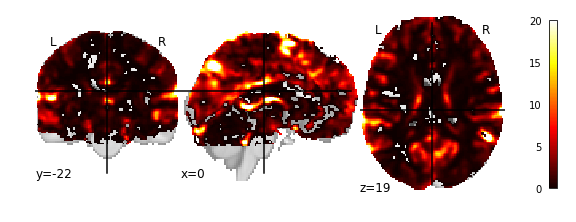

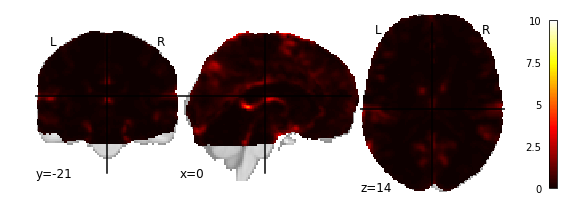

In [407]:
beta = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/flame1/cope1.nii.gz')
plotting.plot_stat_map(beta, vmax=10)
sigma2 = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz')
plotting.plot_stat_map(sigma2, vmax=3)
Sigma2 = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/flame1/mean_random_effects_var1.nii.gz')
plotting.plot_stat_map(Sigma2, vmax=20)

varcope = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')
plotting.plot_stat_map(varcope, vmax=10)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


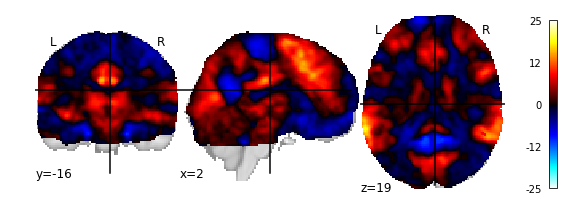

In [408]:
t_part = nib.Nifti1Image(beta.get_data()/np.sqrt(sigma2.get_data()), affine=sigma2.affine)
plotting.plot_stat_map(t_part, vmax=25)

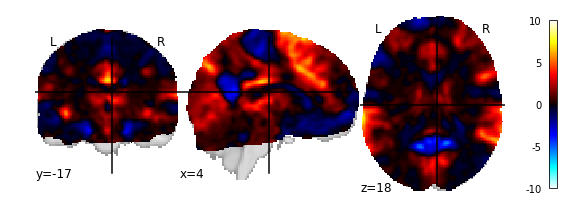

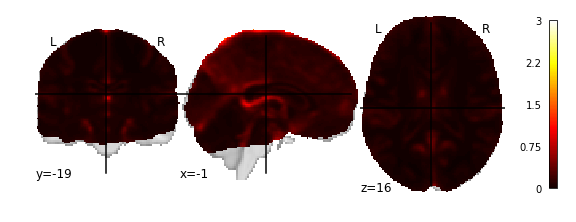

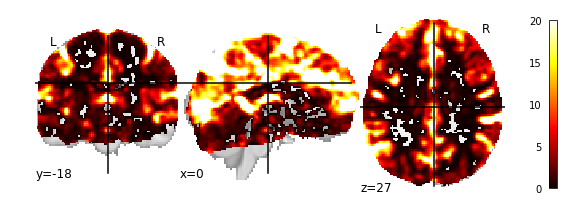

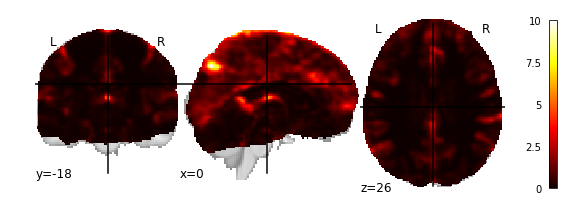

In [409]:
beta = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/cope1.nii.gz')
plotting.plot_stat_map(beta, vmax=10)
sigma2 = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz')
plotting.plot_stat_map(sigma2, vmax=3)
Sigma2 = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/mean_random_effects_var1.nii.gz')
plotting.plot_stat_map(Sigma2, vmax=20)

varcope = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')
plotting.plot_stat_map(varcope, vmax=10)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


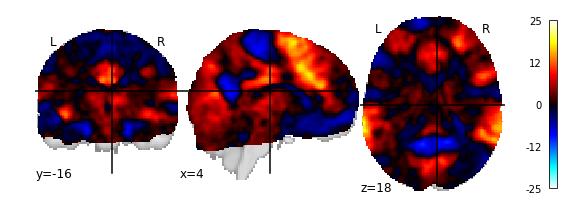

In [410]:
t_part = nib.Nifti1Image(beta.get_data()/np.sqrt(sigma2.get_data()), affine=sigma2.affine)
plotting.plot_stat_map(t_part, vmax=25)

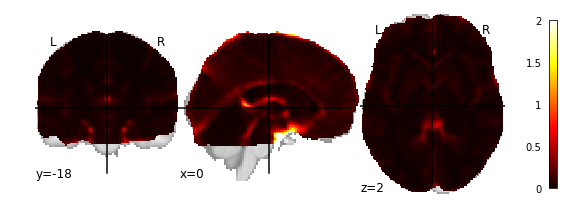

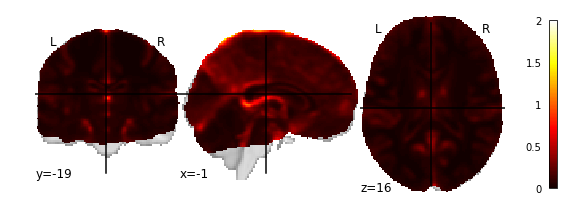

In [401]:
varcope = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz')
plotting.plot_stat_map(varcope, vmax=2)
varcope = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz')
plotting.plot_stat_map(varcope, vmax=2)

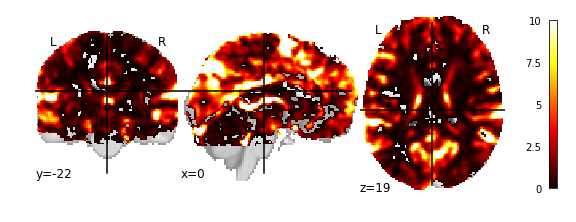

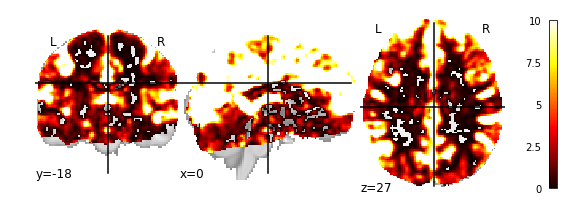

In [398]:
varcope = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/flame1/mean_random_effects_var1.nii.gz')
plotting.plot_stat_map(varcope, vmax=10)
varcope = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/mean_random_effects_var1.nii.gz')
plotting.plot_stat_map(varcope, vmax=10)

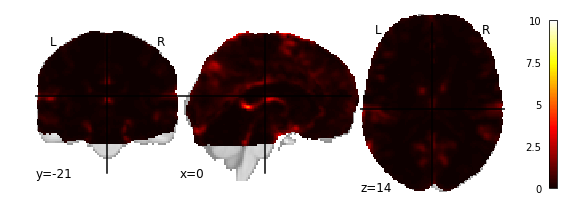

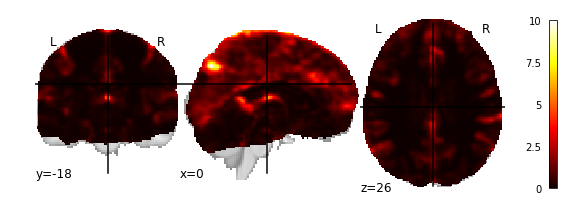

In [397]:
varcope = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')
plotting.plot_stat_map(varcope, vmax=10)
varcope = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')
plotting.plot_stat_map(varcope, vmax=10)

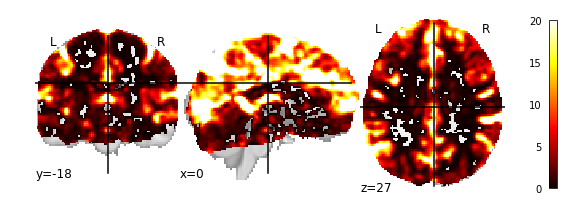

In [384]:
Sigma2 = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/mean_random_effects_var1.nii.gz')
plotting.plot_stat_map(Sigma2, vmax=20)

In [ ]:
sigma2 = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')
plotting.plot_stat_map(sigma2)

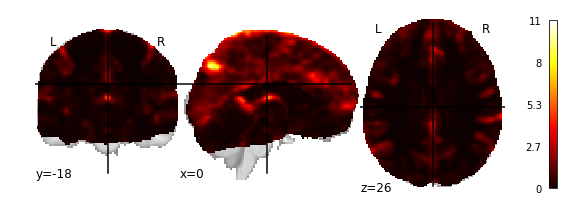

In [383]:
sigma2 = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')
plotting.plot_stat_map(sigma2)

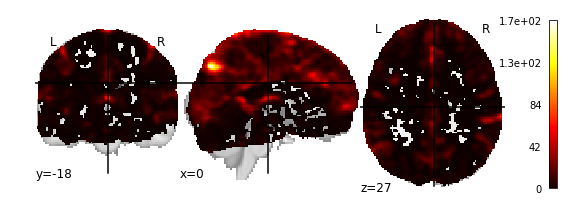

In [381]:
Sigma2 = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/flame1/mean_random_effects_var1.nii.gz')
plotting.plot_stat_map(Sigma2)

## 0 mm, flame1

In [266]:
nii_templ = './flameo/{}/smoothing-{}/contrast-{}/{}/zstat1.nii.gz'
contrasts = ['failed_stop-go_trial', 'successful_stop-go_trial', 'failed_stop-successful_stop']
runmode = 'flame1'
zmaps_se_flame1_0mm = {contrast: nib.load(nii_templ.format('se', 0, contrast, runmode))
                       for contrast in contrasts}
zmaps_me_flame1_0mm = {contrast: nib.load(nii_templ.format('me', 0, contrast, runmode))
                       for contrast in contrasts}

thresholds_se = [map_threshold(zmaps_se_flame1_0mm[contr], level=0.05, height_control='fdr')[1] for contr in contrasts]
thresholds_me = [map_threshold(zmaps_me_flame1_0mm[contr], level=0.05, height_control='fdr')[1] for contr in contrasts]

zmaps_combined, thresholds_combined = order_maps_thresholds([zmaps_se_flame1_0mm, zmaps_me_flame1_0mm],
                                                             [thresholds_se, thresholds_me])

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


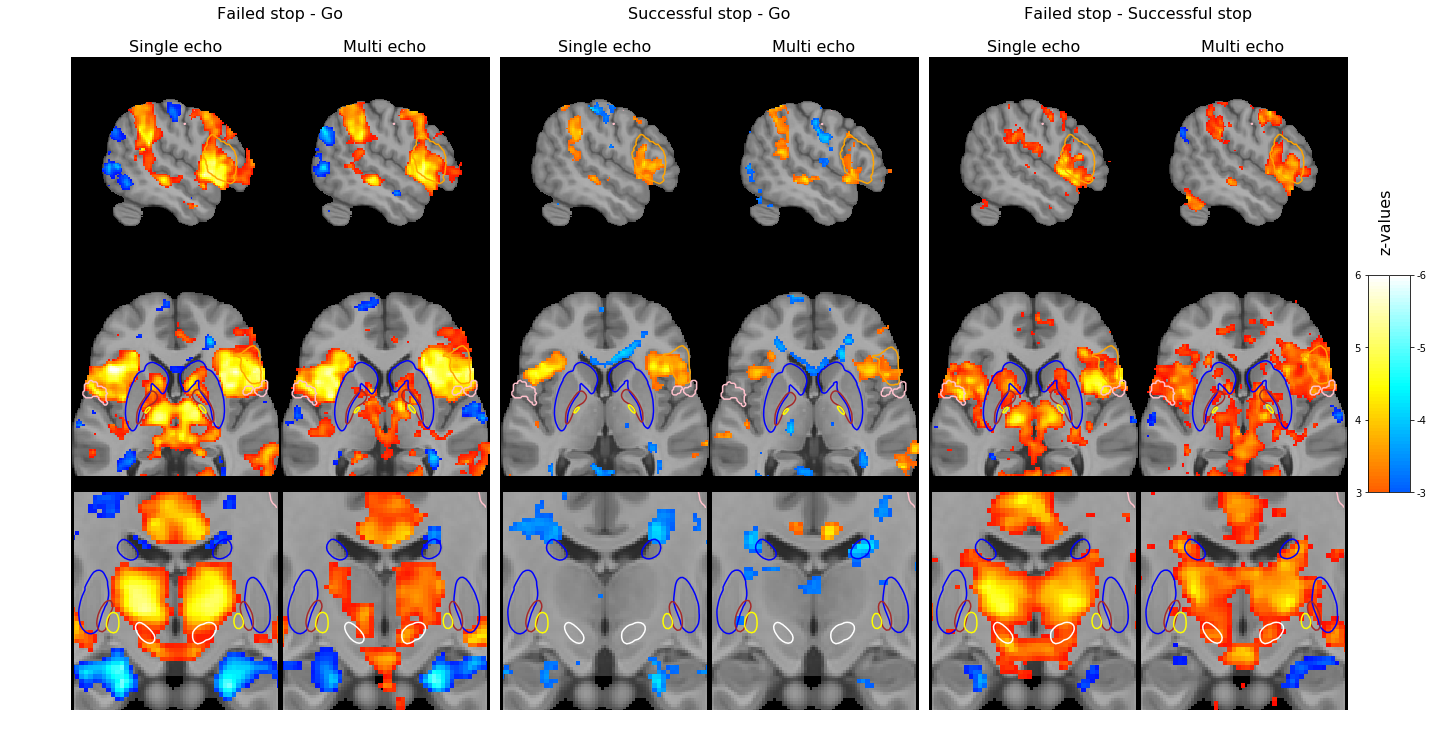

In [267]:
_ = plot_3x6(zmaps_combined, 
             thresholds_combined, 
             contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop')
             )

In [268]:
nii_templ = './flameo/{}/smoothing-{}/contrast-{}/{}/zstat1.nii.gz'
contrasts = ['failed_stop-go_trial', 'successful_stop-go_trial', 'failed_stop-successful_stop']
runmode = 'fe'
zmaps_se_fe_0mm = {contrast: nib.load(nii_templ.format('se', 0, contrast, runmode))
                       for contrast in contrasts}
zmaps_me_fe_0mm = {contrast: nib.load(nii_templ.format('me', 0, contrast, runmode))
                       for contrast in contrasts}

thresholds_se = [map_threshold(zmaps_se_fe_0mm[contr], level=0.05, height_control='fdr')[1] for contr in contrasts]
thresholds_me = [map_threshold(zmaps_me_fe_0mm[contr], level=0.05, height_control='fdr')[1] for contr in contrasts]

zmaps_combined, thresholds_combined = order_maps_thresholds([zmaps_se_fe_0mm, zmaps_me_fe_0mm],
                                                            [thresholds_se, thresholds_me])

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


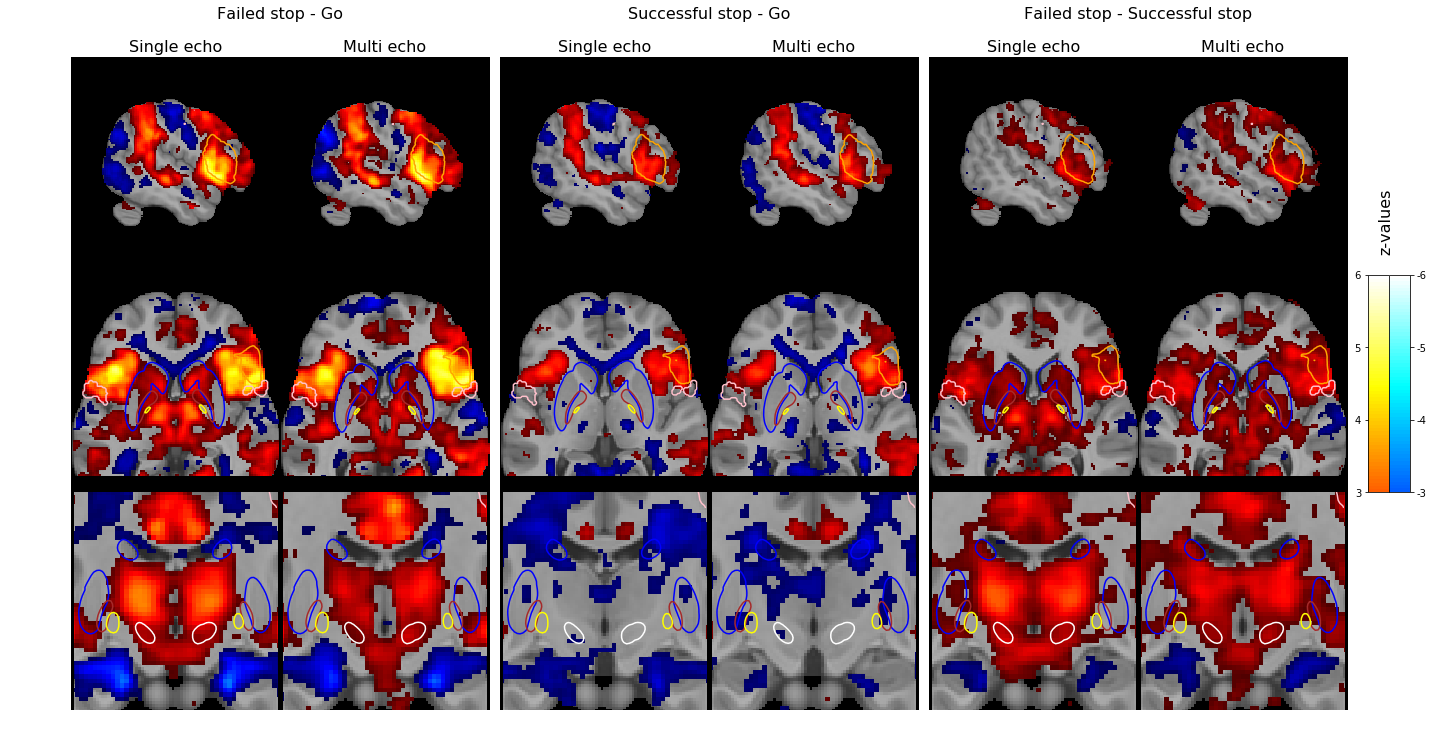

In [288]:
_ = plot_3x6(zmaps_combined, 
             thresholds_combined, 
             contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop'),
             vmax=20,
             )

### Extract influence on t-values:

$t = \frac{\beta}{\sqrt{variance}}$

For fixed-effects: variance = within-subject variance

For random-effects: variance = within + between subject variance

Beta's and variances are given

In [274]:
!ls flameo/me/smoothing-0/contrast-failed_stop-go_trial/fe

cope1.nii.gz			 tdof_t1.nii.gz   zflame1lowertstat1.nii.gz
cope2.nii.gz			 tdof_t2.nii.gz   zflame1lowertstat2.nii.gz
logfile				 tstat1.nii.gz	  zflame1uppertstat1.nii.gz
mask.nii.gz			 tstat2.nii.gz	  zflame1uppertstat2.nii.gz
mean_random_effects_var1.nii.gz  varcope1.nii.gz  zstat1.nii.gz
pe1.nii.gz			 varcope2.nii.gz  zstat2.nii.gz
res4d.nii.gz			 weights1.nii.gz


In [293]:
mean_var = contrasts_se['failed_stop - go_trial'][1].get_data().mean(3)

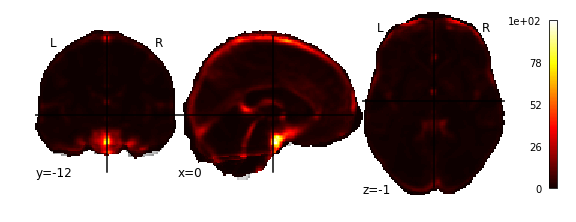

In [297]:
plotting.plot_stat_map(nib.Nifti1Image(mean_var, affine=contrasts_se['failed_stop - go_trial'][1].affine))

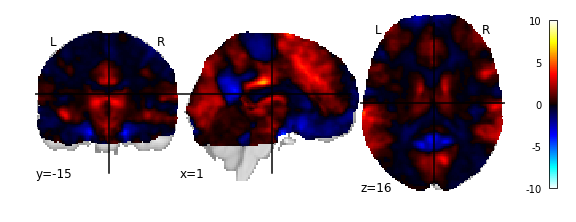

In [278]:
plotting.plot_stat_map('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/fe/cope1.nii.gz', vmax=10)

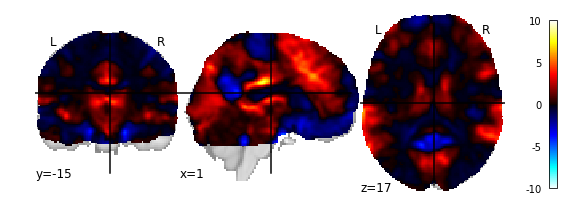

In [279]:
plotting.plot_stat_map('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/ols/cope1.nii.gz', vmax=10)

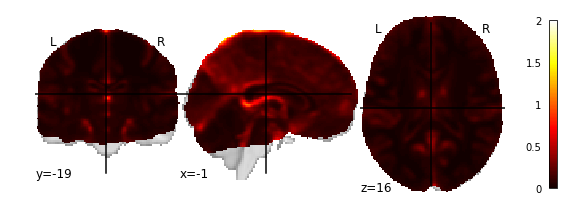

In [305]:
plotting.plot_stat_map('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz', vmax=2)

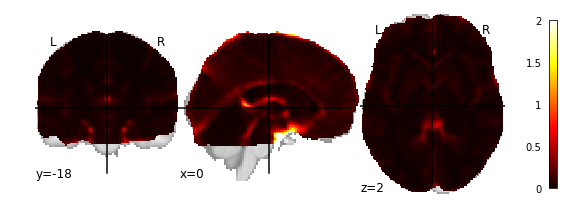

In [306]:
plotting.plot_stat_map('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz', vmax=2)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


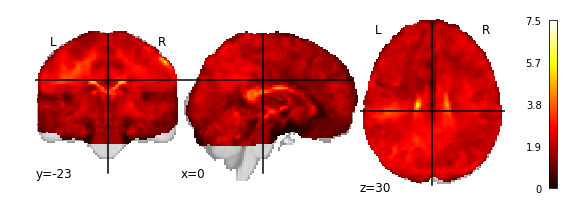

In [308]:
me_sigma2 = nib.load('./flameo/me/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz')
se_sigma2 = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz')

var_ratio = nib.Nifti1Image(me_sigma2.get_data()/se_sigma2.get_data(), me_sigma2.affine)
plotting.plot_img(var_ratio, )

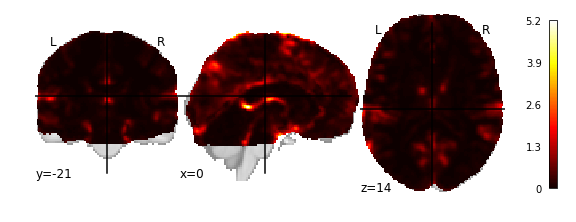

In [283]:
plotting.plot_stat_map('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


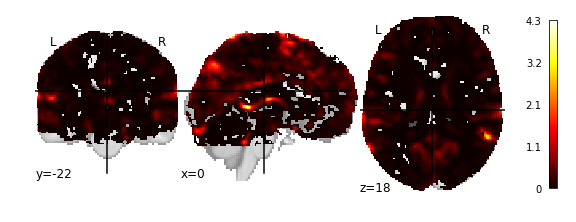

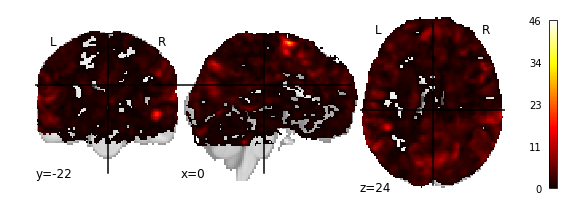

In [300]:
fe_var = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/fe/varcope1.nii.gz')
re_var = nib.load('./flameo/se/smoothing-0/contrast-failed_stop-go_trial/flame1/varcope1.nii.gz')

inter_ind_var = nib.Nifti1Image(re_var.get_data() - fe_var.get_data(), affine=fe_var.affine)
ratio = nib.Nifti1Image(inter_ind_var.get_data()/fe_var.get_data(), affine=fe_var.affine)

plotting.plot_stat_map(inter_ind_var)

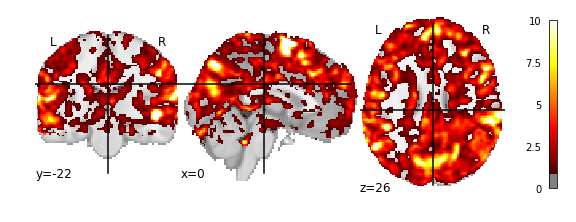

In [303]:
plotting.plot_stat_map(ratio, threshold=1, vmax=10)

### 5 mm, fixed effects

ValueError: minvalue must be less than or equal to maxvalue

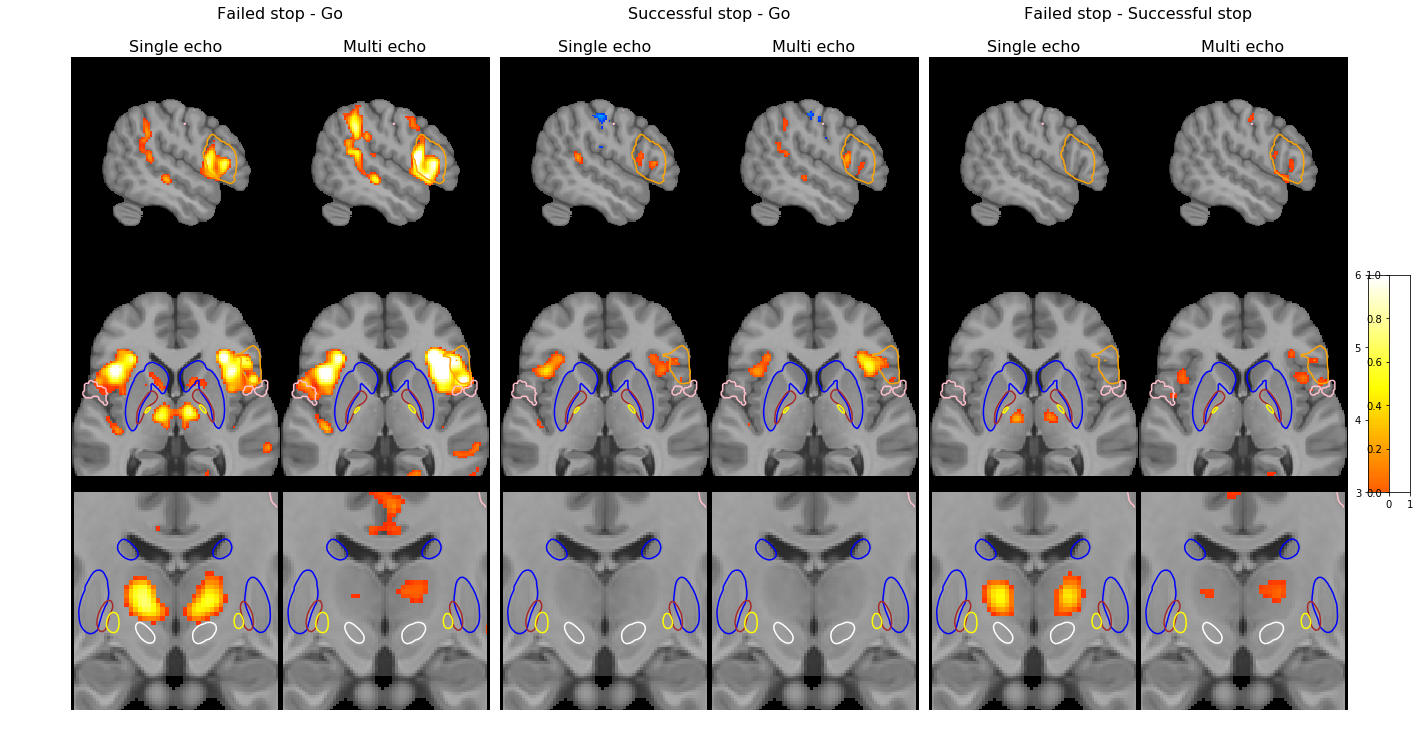

In [239]:
runmode = 'fe'
smooth = 5
zmaps_se_fe_5mm = {contrast: nib.load(nii_templ.format('se', smooth, contrast, runmode))
                       for contrast in contrasts}
zmaps_me_fe_5mm = {contrast: nib.load(nii_templ.format('me', smooth, contrast, runmode))
                       for contrast in contrasts}

zmaps_combined = order_maps_thresholds([zmaps_se_fe_5mm, zmaps_me_fe_5mm])
_ = plot_3x6(zmaps_combined, 
             2.6, 
             contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop')
             )

In [ ]:
### 0 mm, flame1

In [ ]:
runmode = 'flame1'
smooth = 0
zmaps_se_flame1_0mm = {contrast: nib.load(nii_templ.format('se', smooth, contrast, runmode))
                       for contrast in contrasts}
zmaps_me_flame1_0mm = {contrast: nib.load(nii_templ.format('me', smooth, contrast, runmode))
                       for contrast in contrasts}

zmaps_combined = order_maps_thresholds([zmaps_se_flame1_5mm, zmaps_me_flame1_5mm])
_ = plot_3x6(zmaps_combined, 
             2.6, 
             contrast_names=('Failed stop - Go', 
                             'Successful stop - Go',
                             'Failed stop - Successful stop')
             )

### 0mm, fixed effects

In [ ]:
# make designs

In [43]:
# design.mat
with open('./test_flameo/design.mat', 'w') as f:
    f.write(design_str)
# print(design_str)

In [44]:
# contrasts
# print(con_str)
with open('./test_flameo/design.con', 'w') as f:
    f.write(con_str)

In [45]:
# print(grp_str)
with open('./test_flameo/design.grp', 'w') as f:
    f.write(grp_str)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [32]:
nib.save(copes_4D, './test_flameo/copes4D.nii.gz')
nib.save(varcopes_4D, './test_flameo/varcopes4D.nii.gz')

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [36]:
!ls ./test_flameo/

copes4D.nii.gz
design.con
design.grp
design.mat
sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
varcopes4D.nii.gz


In [35]:
# !cp ./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz ./test_flameo/

In [ ]:
# cmd
flameo --cope=copes4D.nii.gz --mask=sub-01_ses-se_task-stop_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz --varcope=varcopes4D.nii.gz --dm=design.mat --tc=design.con --cs=design.grp --runmode=fe --logdir=